In [1]:
# https://www.tensorflow.org/tutorials/generative/autoencoder#second_example_image_denoising
# 이 튜토리얼에서는 3가지 예(기본 사항, 이미지 노이즈 제거 및 이상 감지)를 통해
#  autoencoder를 소개합니다.

# autoencoder는 입력을 출력에 복사하도록 훈련된 특수한 유형의 신경망입니다.
#  예를 들어, 손으로 쓴 숫자의 이미지가 주어지면 autoencoder는 먼저 이미지를
#  더 낮은 차원의 잠재 표현으로 인코딩한 다음 잠재 표현을 다시 이미지로 디코딩합니다.
#  autoencoder는 재구성 오류를 최소화하면서 데이터를 압축하는 방법을 학습합니다.

# autoencoder에 대해 자세히 알아보려면 Ian Goodfellow, Yoshua Bengio 및
#  Aaron Courville의 딥 러닝에서 14장을 읽어보세요

In [2]:
# TensorFlow 및 기타 라이브러리 가져오기
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model


from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# import os as os
# os.environ [ "TF_FORCE_GPU_ALLOW_GROWTH" ] = "true"

In [3]:
# import os as os
# os.environ [ "TF_FORCE_GPU_ALLOW_GROWTH" ] = "true"

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
session = InteractiveSession(config=config)

In [4]:
# 두 번째 예: 이미지 노이즈 제거

# autoencoder는 이미지에서 노이즈를 제거하도록 훈련될 수도 있습니다.
#  다음 섹션에서는 각 이미지에 임의의 노이즈를 적용하여 Fashion MNIST 데이터세트의 노이즈 버전을 생성합니다.
#  그런 다음 노이즈가 있는 이미지를 입력으로 사용하고 원본 이미지를 대상으로 사용하여 autoencoder를 훈련합니다.

# 이전에 수정한 내용을 생략하기 위해 데이터세트를 다시 가져오겠습니다.
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [5]:
# 데이터 size 변경하기 (차원 변경)
print(x_train.shape)
# (60000, 28, 28)

# numpy 방법
# np.expand_dims(train_x, -1) 
#  train_x 위치에 변경하려는 배열을 넣어준다.
#  -1은 가장 뒷부분의 차원을 추가하여준다는 것을 알 수 있다.
new_x_train = np.expand_dims(x_train, -1)
print(new_x_train.shape)
# (60000, 28, 28, 1)

(60000, 28, 28)
(60000, 28, 28, 1)


In [6]:
# tensorflow 방법 1
# numpy 방법과 비슷하다는 것을 알 수 있다.
new_x_train = tf.expand_dims(x_train, -1)
print(new_x_train.shape)
# (60000, 28, 28, 1)

(60000, 28, 28, 1)


In [7]:
# tensorflow 방법 2
# train_x [..., tf.newaxis]
#  이 방법은 [] 안에 기존의 배열을...으로 적고,
#  추가하고 싶은 위치에 tf.newaxis를 적어주면 간단히 size 변경이 된다.
new_x_train = x_train[..., tf.newaxis]
print(new_x_train.shape)
# (60000, 28, 28, 1)
new_x_train = x_train[tf.newaxis, ...]
print(new_x_train.shape)
# (1, 60000, 28, 28)

(60000, 28, 28, 1)
(1, 60000, 28, 28)


In [8]:
# 차원 축소
# > 차원을 축소하는 방법은 np.squeeze()를 활용하면 간단히 가능하다.
# np.squeeze 내부에는 축소하고 싶은 인덱스를 넣어주면 된다.
#  squeeze는 1차원인 축을 모두 제거해 준다
s_x_train = np.squeeze(new_x_train[0])
print(s_x_train.shape)

(60000, 28, 28)


In [9]:
# https://libertegrace.tistory.com/entry/2-Tensorflow20-Xtrain-Data-Preprocess-using-MNIST
# 3-1. X__train 데이터 shape 확인 후 차원 수 늘리기 
# 일반적으로 이미지 데이터셋을 보면 (Batch Size, Height, Width, Channel)의 차원이 들어갑니다. 
# 여기서 Channel이 gray scale이거나 하면 (Batch Size, Height, Width)까지만 나오는데,
#  이를 (Batch Size, Height, Width, Channel)이렇게바꿔주고 싶을 때 필요합니다.
# tf.newaxis 사용
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape, x_test.shape)
#(60000, 28, 28, 1) (10000, 28, 28, 1)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [10]:
# 3-2. X__train 데이터 shape 확인 후 차원 수 줄이기
# matplotlib로 이미지 시각화 할 때는 gray scale의 이미지는 3번 째 dimension이
#  없으므로, 2개의 dimension으로 차원 조절해 주어야 합니다. .squeeze이용

# display = np.sqeeze(new_train_x[0])#.sqeeze 확인
# display.shape

# 이미지에 임의의 노이즈를 추가합니다.
# 텐서플로우에서 random.normal 함수로 정규분포 난수를 발생시키는 간단한 샘플입니다.
# 이미지에 임의의 노이즈를 추가합니다.
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

# tf.clip_by_value
# 텐서 값을 지정된 최소 및 최대로 자릅니다.
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

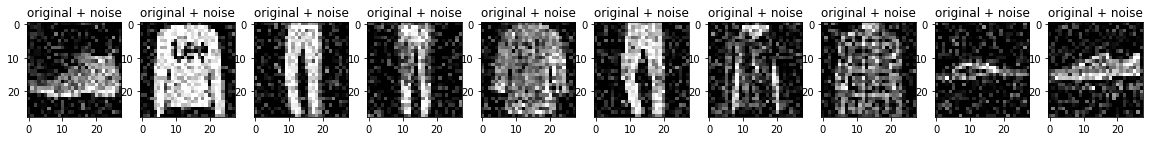

In [11]:
# 노이즈가 있는 이미지를 플롯합니다.
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [12]:
# 컨볼루셔널 autoencoder 정의하기
# 이 예제에서는 encoder에 Conv2D 레이어를 사용하고 decoder에
#  Conv2DTranspose 레이어를 사용하여 컨볼루셔널 autoencoder를 훈련합니다.
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [13]:
autoencoder = Denoise()

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 12s 2ms/step - loss: 0.0160 - val_loss: 0.0099
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0092 - val_loss: 0.0088
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0081 - val_loss: 0.0080
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 7/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0073 - val_loss: 0.0074
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.00

In [14]:
# encoder의 요약을 살펴보겠습니다.
#  이미지가 28x28에서 7x7로 어떻게 다운샘플링되는지 확인하세요.
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [15]:

# decoder는 이미지를 7x7에서 28x28로 다시 업샘플링합니다.
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [16]:
# autoencoder에서 생성된 노이즈가 있는 이미지와 노이즈가 제거 된 이미지를 모두 플롯합니다.
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

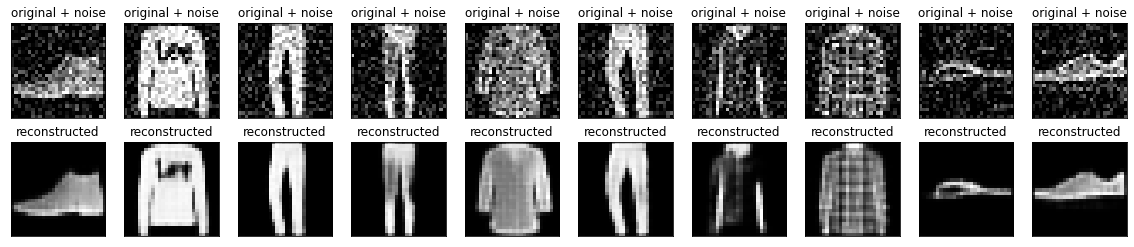

In [17]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()